# S-N-VAE Model Testing Framework

In [1]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /notebooks


# Hyperparameters

In [2]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed':0,
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['R1', 'S1', 'R1', 'S1', 'R1']  # 5 factors total
use_torch_compile = False  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 1

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'beta_s_n_vae'      # S-N-VAE Beta loss
loss_kwargs = {
    'beta': 16,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'gaussian',  # Reconstruction distribution
    'log_kl_components': True
}

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = True

Using GPU


# Reproducibility

In [3]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 0, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [4]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [ ]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate S-N-VAE Loss
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

# Shapes3d

## Load dataset

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

if determinism_kwargs is not None:
    shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_3dshapes, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")

Loaded 3D Shapes dataset with 480000 samples.


## Train

In [7]:
shapes3d_loss_kwargs = loss_kwargs.copy()
shapes3d_loss_kwargs.update({'beta': 16})

In [8]:
print("\n===== Training S-N-VAE on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, 
                                                                        shapes3d_loss_kwargs, 
                                                                        latent_factor_topologies)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss=loss_fn_3dshapes,
                                      optimizer=optimizer_3dshapes,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_3dshapes.train(step_unit=train_step_unit, max_steps=num_train_steps, dataloader=shapes3d_dataloader)


===== Training S-N-VAE on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: s_n_vae_locatello
Latent factor topologies: ['R1', 'S1', 'R1', 'S1', 'R1']
Loss: beta_s_n_vae (rec_dist=gaussian), kwargs={'beta': 16, 'latent_factor_topologies': ['R1', 'S1', 'R1', 'S1', 'R1'], 'rec_dist': 'gaussian', 'log_kl_components': True}
Optimizer: Adam
---------------------------


{'logs': {'train_losses_log': [{'loss': 1773.426723022461,
    'rec_loss': 1766.20619140625,
    'kl_loss': 0.45128350123763084,
    'kl_loss_0_R1': 0.1148933318676427,
    'kl_loss_1_S1': 0.020282162437215447,
    'kl_loss_2_R1': 0.1775145991286263,
    'kl_loss_3_S1': 0.016775204548612237,
    'kl_loss_4_R1': 0.12181820323225111,
    'iter': 200,
    'epoch': 0.02666666666666667},
   {'loss': 1330.6216583251953,
    'rec_loss': 1284.989334716797,
    'kl_loss': 2.8520202922821043,
    'kl_loss_0_R1': 0.5148296697437763,
    'kl_loss_1_S1': 0.0011157383769750595,
    'kl_loss_2_R1': 1.1618187026679516,
    'kl_loss_3_S1': 0.0009636982996016741,
    'kl_loss_4_R1': 1.173292477428913,
    'iter': 400,
    'epoch': 0.05333333333333334},
   {'loss': 1027.1477249145507,
    'rec_loss': 953.1236810302735,
    'kl_loss': 4.626502994298935,
    'kl_loss_0_R1': 1.214935545027256,
    'kl_loss_1_S1': 0.0007222723215818405,
    'kl_loss_2_R1': 1.7174219840765,
    'kl_loss_3_S1': 0.0004768496099

### Visualization

In [9]:
visualizer_3dshapes = utils.visualize.SNVAEVisualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

#### Reconstructions

Plotting random reconstructions...


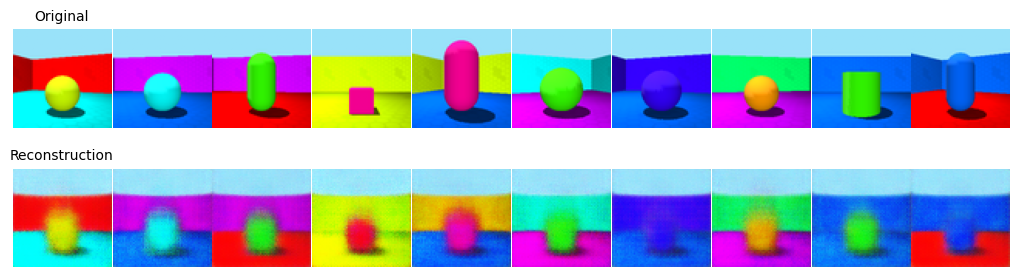

Plotting reconstructions from specific indices...


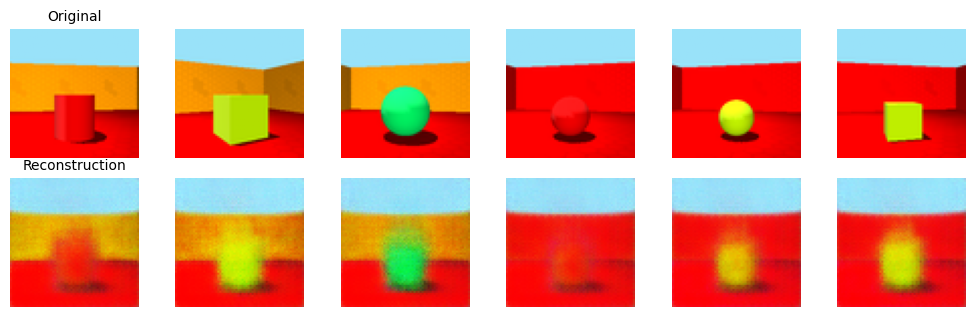

In [10]:
print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024]  # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

#### Latent traversal

Plotting latent traversals...


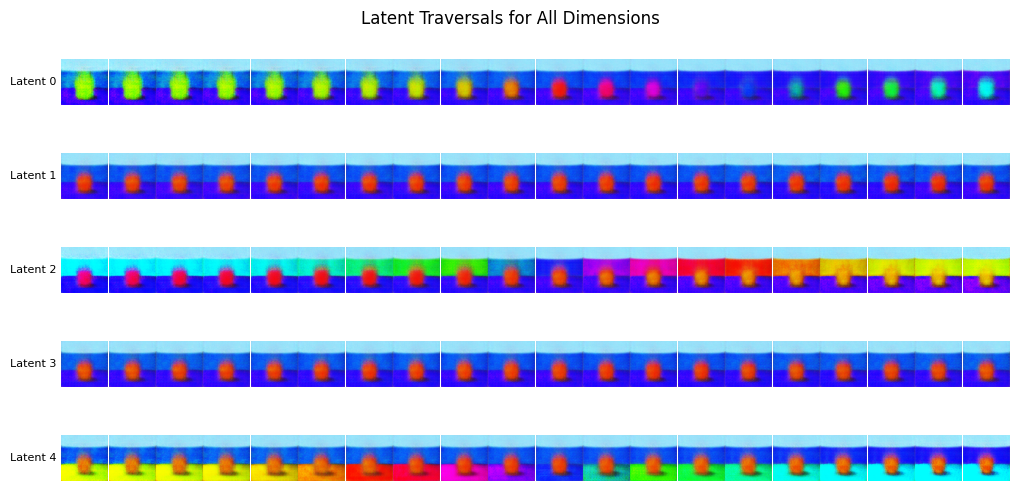

In [11]:
print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

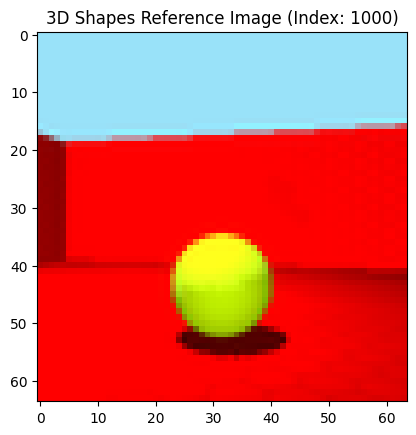

In [12]:
ref_img_idx = 1000
ref_img = shapes3d_dataset[ref_img_idx][0]
plt.imshow(ref_img.permute(1, 2, 0).cpu().numpy())
plt.title(f"3D Shapes Reference Image (Index: {ref_img_idx})")
plt.show()

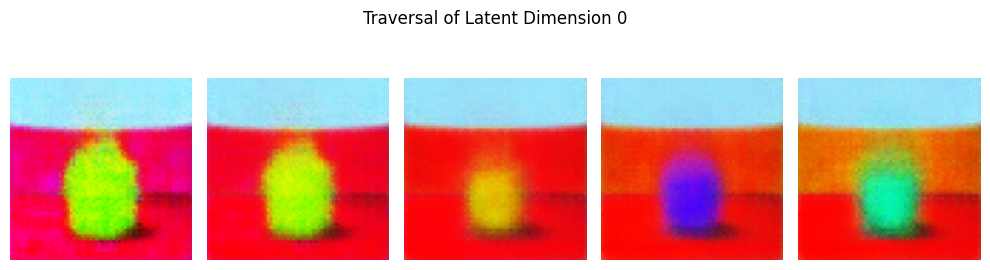

In [14]:
# single latent traversal based on the reference image
latent_factor_idx = 0  # Index of the latent dimension to traverse
visualizer_3dshapes.plot_single_latent_traversal(latent_factor_idx, 
                                                 ref_img=ref_img, 
                                                 num_samples=5,
                                                 max_traversal_type='probability', 
                                                 max_traversal=0.99)
plt.show()

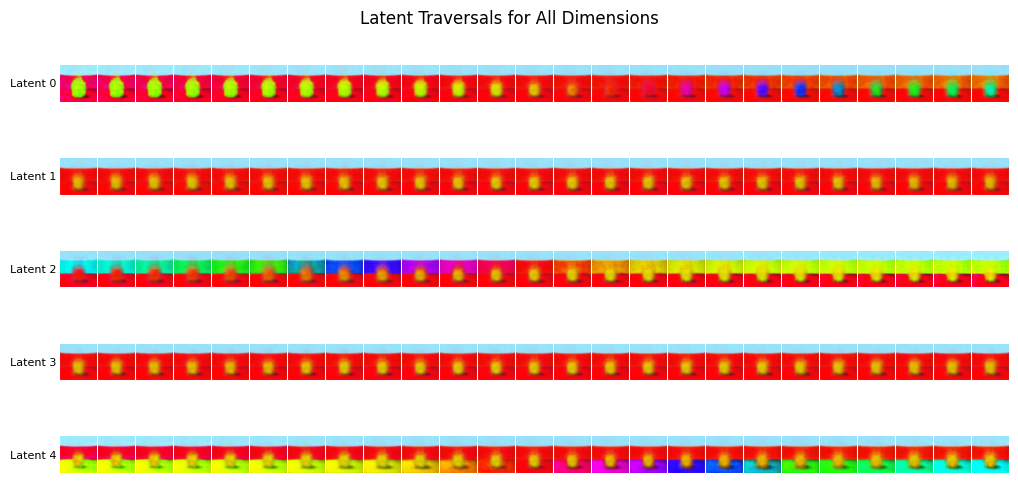

In [15]:
visualizer_3dshapes.plot_all_latent_traversals(ref_img=ref_img, 
                                               num_samples=25,  
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.99,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )
plt.show()

## Metric Evaluation

In [ ]:
# metrics_to_compute = [
#     {'name': 'dci', 'args':{'num_train':5000, 'num_test':1000}}, # Added num_train and num_test
#     {'name': 'mig', 'args':{}} # MIG uses default args (num_bins=20, num_workers=8, etc.)
# ]

# metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

# print("\n===== Computing Metrics for 3D Shapes =====")
# metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
#                                                               data_loader=shapes3d_dataloader, 
#                                                               device=device)
# print("3D Shapes Metrics:", metrics_results_3dshapes)

# dSprites

In [5]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [18]:
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

loss_kwargs_dsprites = {
    'beta': 8,
    'latent_factor_topologies': latent_factor_topologies,
    'rec_dist': 'bernoulli',  # Reconstruction distribution
    'log_kl_components': True
}

train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 200


In [19]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: beta_s_n_vae (rec_dist=bernoulli), kwargs={'beta': 8, 'latent_factor_topologies': ['S1', 'R1', 'R1'], 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
---------------------------


{'logs': {'train_losses_log': [{'loss': 1281.651668701172,
    'rec_loss': 1250.067230834961,
    'kl_loss': 3.9480555547773837,
    'kl_loss_0_S1': 0.38001516051590445,
    'kl_loss_1_R1': 2.0278760557062925,
    'kl_loss_2_R1': 1.5401643417589366,
    'iter': 200,
    'epoch': 0.3125},
   {'loss': 395.00429794311526,
    'rec_loss': 337.2478366088867,
    'kl_loss': 7.219557681083679,
    'kl_loss_0_S1': 1.220372267663479,
    'kl_loss_1_R1': 3.0783662962913514,
    'kl_loss_2_R1': 2.920819103717804,
    'iter': 400,
    'epoch': 0.625},
   {'loss': 257.547505569458,
    'rec_loss': 197.26871215820313,
    'kl_loss': 7.534849121570587,
    'kl_loss_0_S1': 1.5598532205820084,
    'kl_loss_1_R1': 3.0505281829833986,
    'kl_loss_2_R1': 2.924467704296112,
    'iter': 600,
    'epoch': 0.9375},
   {'loss': 242.22807022094727,
    'rec_loss': 182.9082029724121,
    'kl_loss': 7.414983448982238,
    'kl_loss_0_S1': 1.629236370921135,
    'kl_loss_1_R1': 2.943933606147766,
    'kl_loss_2_R1

In [13]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


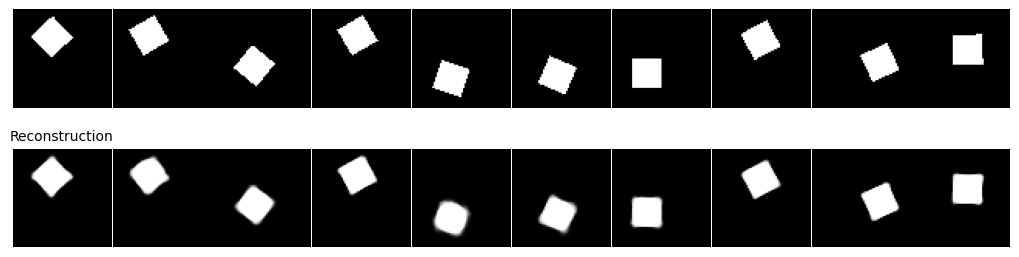

Plotting reconstructions from specific indices...


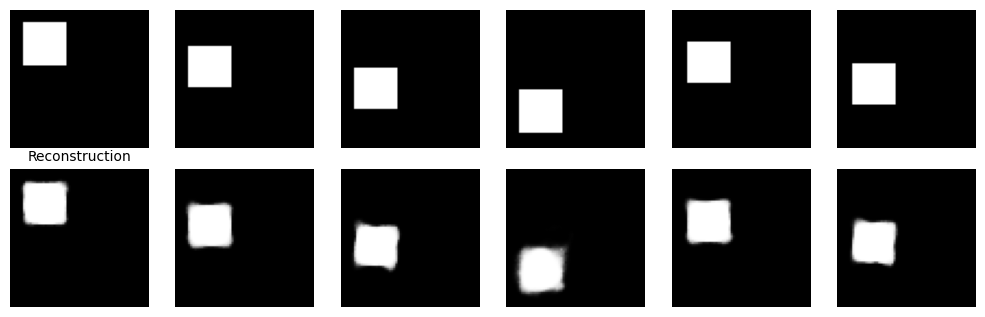

In [14]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


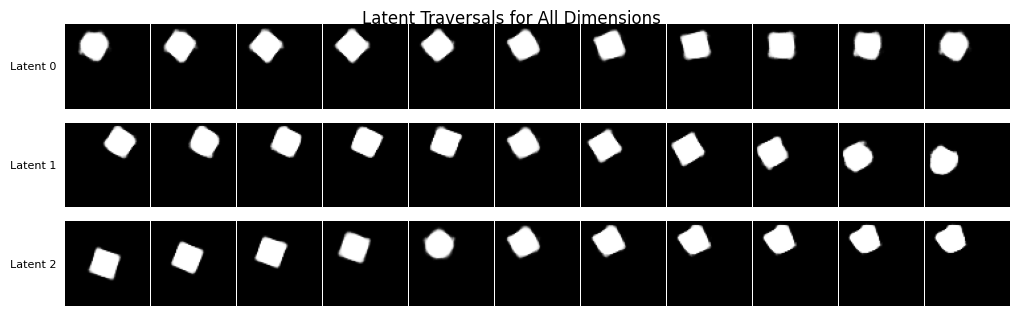

In [17]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=11,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.99,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0
                                               )
plt.show()

In [ ]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 10000  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

In [ ]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=10,
                                                 max_traversal_type='mixed',
                                                 max_traversal=0.95)
plt.show()

In [ ]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=20,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=0.95
                                               )

## Metric Evaluation (dSprites)

In [ ]:
print("\n===== Computing Metrics for dSprites =====")
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)